<br>

# Introdução

In [1]:
#!pip install plotly

In [85]:
import os
import psycopg2
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.graph_objects as go

from plotly.offline import plot
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

In [86]:
try:
    from sabesp import settings
    from dados.models import cantareira
    from django.conf import settings
    print('In Django:\n{}'.format(settings.BASE_DIR))
    in_django = True
except Exception as e:
    print('Not in Django\n{}'.format(e))
    py.init_notebook_mode(connected=True)
    in_django = False

Not in Django
No module named 'sabesp'


In [87]:
data_path = os.path.join('..', 'data')

<br>

# Conversão de Unidades

In [88]:
def m3s_2_hm3(m3s):
    "Converte m3/s em um dia (86400 segundos) para hm3"
    x = m3s * (24*60*60) * 0.000001
    return x

In [89]:
def hm3_2_m3s(hm3):
    "Converte mhm3 para m3/s em um dia (86400 segundos)"
    x = hm3 / (24*60*60) / 0.000001
    return x

<br>

# Get Middle Date

In [90]:
def get_middle_date(start_date, end_date):
    """
    Pega a data do meio entre duas datas.
    Adequado para os labels de gráficos
    Textos inseridos em string
    Retorno em dataetime
    """
    # Get Middle Date
    #start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    #end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    x = (end_date-start_date).days
    x = start_date + timedelta(x/2)
    return x

In [91]:
# Parameters
start_date=date(2017, 5, 29)
end_date=date(2020, 6, 10)

# Function
x = get_middle_date(start_date, end_date)
x

datetime.date(2018, 12, 4)

<br>

# Lê os Dados

In [98]:
def get_df_compiled(in_django):
    # Create blank list
    dfs = []

    # Files
    files = [
        'tab_Cantareira_1990.01.01__1999.12.31.csv',
        'tab_Cantareira_2000.01.01__2009.12.31.csv',
        'tab_Cantareira_2010.01.01__2019.12.31.csv',
        'tab_Cantareira_2020.01.01__2020.07.14.csv',
    ]

    if in_django:
        filepath = os.path.join(settings.BASE_DIR, 'staticfiles', 'data')
    else:
        filepath = os.path.join('..', 'data')

    # Read all Files
    for file in files:
        df = pd.read_csv(
            os.path.join(filepath, file),
            sep=';',
            decimal=','
        )

        df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y', errors='ignore')
        dfs.append(df)

    # Concat
    dfs = pd.concat(dfs)

    # Se no Django...
    if in_django:
        # Read all DB
        query = cantareira.objects.all().values()

        if query.count() > 0:
            df = pd.DataFrame.from_records(query)
            df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d', errors='ignore')

            # Get Max value from csv files
            max_date_csv = max(dfs['data'])

            # Seleciona o deadline
            df = df[df['data'] > max_date_csv]

            # Concat
            df = pd.concat([dfs, df])

    else:
        df = pd.concat([dfs])

    # Results
    return df.sort_values('data')

In [99]:
df = get_df_compiled(in_django)
df.tail()

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
191 2020-07-10              0.2          783.684                 2.5   
192 2020-07-11              0.0          783.668                 2.5   
193 2020-07-12              0.0          783.652                 2.5   
194 2020-07-13              0.0          783.638                 2.5   
195 2020-07-14              0.0          783.621                 2.5   

     atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
191        232.920080              295.456327              199.204147   
192        232.609855              295.456327              199.204147   
193        232.299829              295.456327              199.204147   
194        232.028721              295.456327              199.204147   
195        231.699724              295.456327              199.204147   

     atibainha_volumeoperacional  atibainha_volumeporcentagem  \
191                    33.715933                    35.028748   
192                    33.405707                    34.706442   
193                    33.095682                    34.384345   
194                    32.824574                    34.102681   
195                    32.495577                    33.760874   

     atibainha_volumetotal  ...  sc_precipitacao  \
191             232.920080  ...              0.4   
192             232.609855  ...              0.1   
193             232.299829  ...              0.1   
194             232.028721  ...              0.0   
195             231.699724  ...              0.0   

     sc_variacaovolumeporcentagem  sc_vazaoafluente  sc_vazaojusante  \
191                      -0.12887            16.842              8.1   
192                      -0.10858            20.305              8.1   
193                      -0.11644            17.683              8.1   
194                      -0.12075            17.092              8.1   
195                      -0.10698            19.647              8.1   

     sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
191            9.259           24.27511          24.28902   
192           12.510           24.04239          24.16449   
193            9.619           23.47875          23.45277   
194            9.059           24.34541          24.30211   
195           11.627           24.34541          24.30211   

     sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  
191                542.21735              55.21157         1053.62602  
192                541.15105              55.10299         1052.55972  
193                540.00756              54.98655         1051.41623  
194                538.82170              54.86580         1050.23037  
195                537.77108              54.75882         1049.17975  

[5 rows x 96 columns]

<br>

## Lê PostgreSQL

In [100]:
def concat_dfdb(df):
    # Dados do Banco de Dados (Heroku)
    host = 'ec2-34-239-241-25.compute-1.amazonaws.com'
    database = 'da818piepcotea'
    user = 'aohjlkbcflpjkk'
    port = '5432'
    password='211406869e5c3e2fe81b84ad37f45c0f5c645f4ef834271a70f3918dda00d500'
    
    # Conection
    db = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port,
    )
    cur = db.cursor()

    # Query
    sql = """
    SELECT *
    FROM dados_cantareira
    """
    cur.execute(sql)

    # Transform in Dataframe
    df_db = pd.read_sql_query(sql, db)

    # Close Conection
    db.close()

    # Ajusta da Tabela
    df_db.drop(['id'], axis=1, inplace=True, errors='ignore')
    df_db['data'] = pd.to_datetime(df_db['data'], format='%Y-%m-%d')

    # Seleciona o deadline
    #deadline
    #deadline = '2020-07-10'
    #df = df[df['data'] >= deadline]

    # Concat
    df = pd.concat([df, df_db])

    # Results
    return df

In [102]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)
display(df.head())
display(df.tail())

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
0 1990-01-01              8.9           783.83                2.03   
1 1990-01-02             36.8           783.91                1.07   
2 1990-01-03             20.1           784.07                1.08   
3 1990-01-04              1.4           784.14                1.08   
4 1990-01-05             21.4           784.17                1.09   

   atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
0        238.114230              301.529768              171.244957   
1        239.689515              301.529768              171.244957   
2        242.856146              301.529768              171.244957   
3        244.248284              301.529768              171.244957   
4        244.846170              301.529768              171.244957   

   atibainha_volumeoperacional  atibainha_volumeporcentagem  \
0                    66.869273                    51.325456   
1                    68.444558                    52.534564   
2                    71.611189                    54.965110   
3                    73.003327                    56.033644   
4                    73.601214                    56.492551   

   atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
0             238.114230  ...               NaN              NaN   
1             239.689515  ...               NaN              NaN   
2             242.856146  ...               NaN              NaN   
3             244.248284  ...               NaN              NaN   
4             244.846170  ...               NaN              NaN   

   sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
0              NaN                NaN               NaN   
1              NaN                NaN               NaN   
2              NaN                NaN               NaN   
3              NaN                NaN               NaN   
4              NaN                NaN               NaN   

   sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  url  \
0                      NaN                   NaN                NaN  NaN   
1                      NaN                   NaN                NaN  NaN   
2                      NaN                   NaN                NaN  NaN   
3                      NaN                   NaN                NaN  NaN   
4                      NaN                   NaN                NaN  NaN   

   created_date  
0           NaT  
1           NaT  
2           NaT  
3           NaT  
4           NaT  

[5 rows x 98 columns]

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
292 2021-05-03              0.0          783.729                4.13   
293 2021-05-04              0.0          783.710                5.50   
294 2021-05-05              0.0          783.690                5.50   
295 2021-05-06              0.0          783.665                5.50   
296 2021-05-07              0.0          783.650                5.50   

     atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
292        233.793663              295.456327              199.204147   
293        233.424624              295.456327              199.204147   
294        233.036466              295.456327              199.204147   
295        232.551709              295.456327              199.204147   
296        232.261090              295.456327              199.204147   

     atibainha_volumeoperacional  atibainha_volumeporcentagem  \
292                    34.589516                    35.936346   
293                    34.220477                    35.552937   
294                    33.832319                    35.149666   
295                    33.347562                    34.646033   
296                    33.056943                    34.344098   

     atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
292             233.793663  ...            19.928            10.73   
293             233.424624  ...            12.996            12.10   
294             233.036466  ...            16.356            12.10   
295             232.551709  ...            21.912            11.69   
296             232.261090  ...            13.384            11.69   

     sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
292           12.258           20.45416          20.45958   
293            5.342           22.28948          22.29635   
294            8.708           21.87057          21.87074   
295           15.156           21.63360          21.64751   
296            5.784           22.09928          22.09838   

     sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  \
292                496.01506              50.50700         1007.42373   
293                494.26057              50.32834         1005.66924   
294                492.80606              50.18024         1004.21472   
295                491.86465              50.08438         1003.27332   
296                490.19744              49.91461         1001.60611   

                                                   url  \
292  http://mananciais.sabesp.com.br/api/Mananciais...   
293  http://mananciais.sabesp.com.br/api/Mananciais...   
294  http://mananciais.sabesp.com.br/api/Mananciais...   
295  http://mananciais.sabesp.com.br/api/Mananciais...   
296  http://mananciais.sabesp.com.br/api/Mananciais...   

                        created_date  
292 2021-05-03 13:01:21.463660+00:00  
293 2021-05-04 13:00:41.676851+00:00  
294 2021-05-05 13:00:47.036276+00:00  
295 2021-05-06 13:01:36.728367+00:00  
296 2021-05-07 13:01:09.612008+00:00  

[5 rows x 98 columns]

<br>

## Salva Tabela

In [103]:
def save_df(df, data_path):
    # Save
    df.to_csv(
        os.path.join(data_path, 'tab_Cantareira_compiled.csv'),
        index=False,
        header=True,
        encoding='UTF-8-SIG',
        sep=';',
        decimal=',',
        date_format='%d/%m/%Y'
    )
    return print('Tabela Salva')

In [104]:
#save_df(df)

<br>

# Set Periodo

In [105]:
def set_periodo(data):
    """
    Define o periodo a partir de uma data qualquer, em formato texto
    """
    # Definição do Período Seco
    periodoseco_start = date(data.year, 6, 1)
    periodoseco_end = date(data.year, 11, 30)

    # Ifs
    if data >= periodoseco_start and data <= periodoseco_end:
        periodo = 'Período Seco'
        days2end_periodo = (periodoseco_end - data).days
        
    elif data < periodoseco_start:
        periodo = 'Período Úmido'
        days2end_periodo = (periodoseco_start - data).days
        
    elif data > periodoseco_end:
        periodo = 'Período Úmido'
        x = periodoseco_start + relativedelta(years=1)-timedelta(1)
        days2end_periodo = (x - data).days
        
    else:
        periodo = 'Erro'
        
    return periodo, days2end_periodo, periodoseco_start, periodoseco_end

In [106]:
periodo, days2end_periodo, periodoseco_start, periodoseco_end = set_periodo(start_date)
print(periodo)
print(days2end_periodo)
print(periodoseco_start)
print(periodoseco_end)

Período Úmido
3
2017-06-01
2017-11-30


<br>

# Set Faixas

In [107]:
def set_faixas(vol_porcentagem):
    # Seleciona a Faixa
    if vol_porcentagem >= 0.6:
        faixa = 'Faixa 1 (Normal)'
        faixa_id = 1
    elif vol_porcentagem >= 0.4:
        faixa = 'Faixa 2 (Atenção)'
        faixa_id = 2
    elif vol_porcentagem >= 0.3:
        faixa = 'Faixa 3 (Alerta)'
        faixa_id = 3
    elif vol_porcentagem >= 0.2:
        faixa = 'Faixa 4 (Restrição)'
        faixa_id = 4
    elif vol_porcentagem < 0.2:
        faixa = 'Faixa 5 (Especial)'
        faixa_id = 5
        
    return faixa, faixa_id

In [108]:
def get_faixas(data, df):
    """
    Define o periodo a partir de uma data qualquer, em formato texto
    """

    # Filtra Tabela
    #df = df[df['data'] == pd.Timestamp(data)]
    #df.loc[:, 'data' == pd.Timestamp(data)]
    df.loc[df['data'] == pd.Timestamp(data)]

    # Calcula Campo
    df['sc_calc_volumeporcentagem'] = (
        (df['jaguari_jacarei_volumeoperacional'] +
        df['cachoeira_volumeoperacional'] +
        df['atibainha_volumeoperacional'] +
        df['paivacastro_volumeoperacional']) / 
        (
            (df['jaguari_jacarei_volumemaximo'] +
            df['cachoeira_volumemaximo'] +
            df['atibainha_volumemaximo'] +
            df['paivacastro_volumemaximo'])
            -
            (df['jaguari_jacarei_volumeminimo'] +
            df['cachoeira_volumeminimo'] +
            df['atibainha_volumeminimo'] +
            df['paivacastro_volumeminimo'])
    ))
    
    # Define o Valor
    vol_porcentagem = df.iloc[0]['sc_calc_volumeporcentagem']
    
    # Set Faixas
    faixa, faixa_id = set_faixas(vol_porcentagem)

    # Round
    vol_porcentagem = round(vol_porcentagem*100, 2)

    return (
        data.strftime('%d.%m.%Y'),
        vol_porcentagem,
        faixa,
        faixa_id
    )

In [109]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)
df.head()

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
0 1990-01-01              8.9           783.83                2.03   
1 1990-01-02             36.8           783.91                1.07   
2 1990-01-03             20.1           784.07                1.08   
3 1990-01-04              1.4           784.14                1.08   
4 1990-01-05             21.4           784.17                1.09   

   atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
0        238.114230              301.529768              171.244957   
1        239.689515              301.529768              171.244957   
2        242.856146              301.529768              171.244957   
3        244.248284              301.529768              171.244957   
4        244.846170              301.529768              171.244957   

   atibainha_volumeoperacional  atibainha_volumeporcentagem  \
0                    66.869273                    51.325456   
1                    68.444558                    52.534564   
2                    71.611189                    54.965110   
3                    73.003327                    56.033644   
4                    73.601214                    56.492551   

   atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
0             238.114230  ...               NaN              NaN   
1             239.689515  ...               NaN              NaN   
2             242.856146  ...               NaN              NaN   
3             244.248284  ...               NaN              NaN   
4             244.846170  ...               NaN              NaN   

   sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
0              NaN                NaN               NaN   
1              NaN                NaN               NaN   
2              NaN                NaN               NaN   
3              NaN                NaN               NaN   
4              NaN                NaN               NaN   

   sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  url  \
0                      NaN                   NaN                NaN  NaN   
1                      NaN                   NaN                NaN  NaN   
2                      NaN                   NaN                NaN  NaN   
3                      NaN                   NaN                NaN  NaN   
4                      NaN                   NaN                NaN  NaN   

   created_date  
0           NaT  
1           NaT  
2           NaT  
3           NaT  
4           NaT  

[5 rows x 98 columns]

In [110]:
# Parameters
data = date.today()-timedelta(285)
print(data)

# Results
data_text, vol_porcentagem, faixa, faixa_id = get_faixas(data, df)
print(data_text)
print(vol_porcentagem)
print(faixa)
print(faixa_id)

2021-05-05
05.05.2021
63.47
Faixa 1 (Normal)
1


<br>

# Graph Faixas

In [111]:
def get_graph_faixas(df):
    # Filtra Tabela
    start_date = date(2017, 5, 29)
    df = df[df['data'] >= pd.Timestamp(start_date)].copy()

    # Calcula Campo
    df['sc_calc_volumeporcentagem'] = (
        (df['jaguari_jacarei_volumeoperacional'] +
        df['cachoeira_volumeoperacional'] +
        df['atibainha_volumeoperacional'] +
        df['paivacastro_volumeoperacional']) / 
        (
            (df['jaguari_jacarei_volumemaximo'] +
            df['cachoeira_volumemaximo'] +
            df['atibainha_volumemaximo'] +
            df['paivacastro_volumemaximo'])
            -
            (df['jaguari_jacarei_volumeminimo'] +
            df['cachoeira_volumeminimo'] +
            df['atibainha_volumeminimo'] +
            df['paivacastro_volumeminimo'])
    ))

    # Get Middle Date
    end_date = date.today()
    x = get_middle_date(start_date, end_date)

    # Create Graph
    fig = go.Figure()

    # Create scatter trace of data
    fig.add_trace(
        go.Scatter(
            x=df['data'],
            y=df['sc_calc_volumeporcentagem'],
            name='V.Útil',
            text='Volume Útil (%)',
            # hover_name='sss',
            line={
                'color': '#000066',
                #'dash': 'dash'
            }
        )
    )
    
    # Create scatter trace of text labels
    fig.add_trace(
        go.Scatter(
            x=[x, x, x, x, x],
            y=[0.8, 0.5, 0.35, 0.25, 0.1],
            text=['Faixa 1: Normal',
                  'Faixa 2: Atenção',
                  'Faixa 3: Alerta',
                  'Faixa 4: Restrição',
                  'Faixa 5: Especial',
                  ],
            mode='text',
            showlegend=False,
            hoverinfo='none',
        )
    )
    
    fig.add_shape(
        dict(
            type='rect',
            x0=start_date,
            y0=0.6,
            x1=max(df['data']),
            y1=1,
            fillcolor='#476ab4',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color="Green",
                width=1
            ),
        ))

    fig.add_shape(
        dict(
            type='rect',
            x0=start_date,
            y0=0.4,
            x1=max(df['data']),
            y1=0.6,
            fillcolor='#97d4ae',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='Green',
                width=1
            ),
        ))

    fig.add_shape(
        dict(
            type='rect',
            x0=start_date,
            y0=0.3,
            x1=max(df['data']),
            y1=0.4,
            fillcolor='#f4f3ca',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='Green',
                width=1
            ),
        ))

    fig.add_shape(
        dict(
            type='rect',
            x0=start_date,
            y0=0.2,
            x1=max(df['data']),
            y1=0.3,
            fillcolor='#ffa75f',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='Green',
                width=1
            ),
        ))

    fig.add_shape(
        dict(
            type='rect',
            x0=start_date,
            y0=0,
            x1=max(df['data']),
            y1=0.2,
            fillcolor='#bd3b3b',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='Green',
                width=1
            ),
        ))

    # Layout
    fig.update_layout(
        # title='Faixas de Operação',
        yaxis={'title': 'Volume Útil (%)'},
        # xaxis={'title': 'Data'}
    )
    fig.update_layout(yaxis_tickformat='%')
    fig.update_layout(yaxis_tickformat='.2%')
    fig.update_layout(xaxis_tickformat='%d %B<br>%Y')
    fig.update_layout(showlegend=False)

    # Results
    plt = plot(fig, output_type='div', include_plotlyjs=False)
    return plt, fig

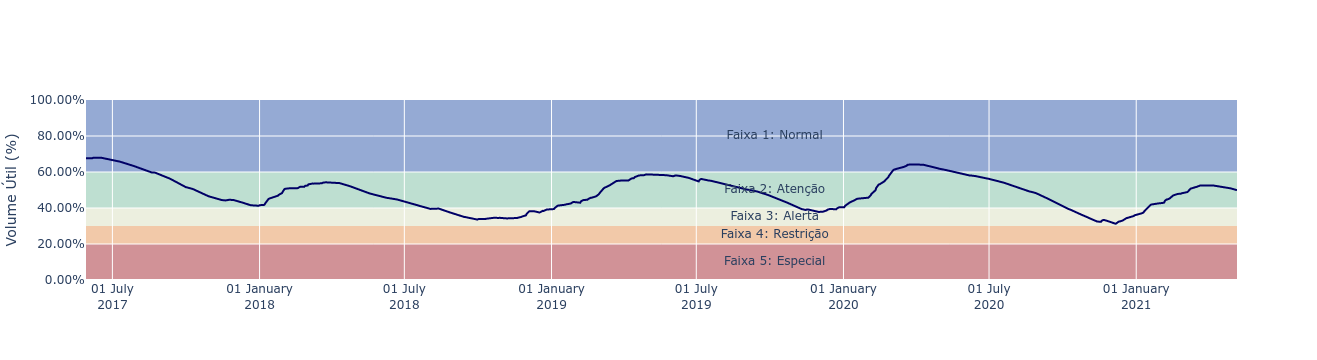

In [113]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)

plt, fig = get_graph_faixas(df)
fig

<br>

# Graph Reservatórios

In [114]:
def get_graph_reservatorios(date_series, data_plot):
    # Graph
    fig = go.Figure()
    scatter = go.Scatter(
        x=date_series,
        y=data_plot,
        mode='lines',
        name='test',
        opacity=1,
        marker_color='blue'
    )

    fig.add_trace(scatter)
    plt = plot(fig, output_type='div', include_plotlyjs=False)
    return plt, fig

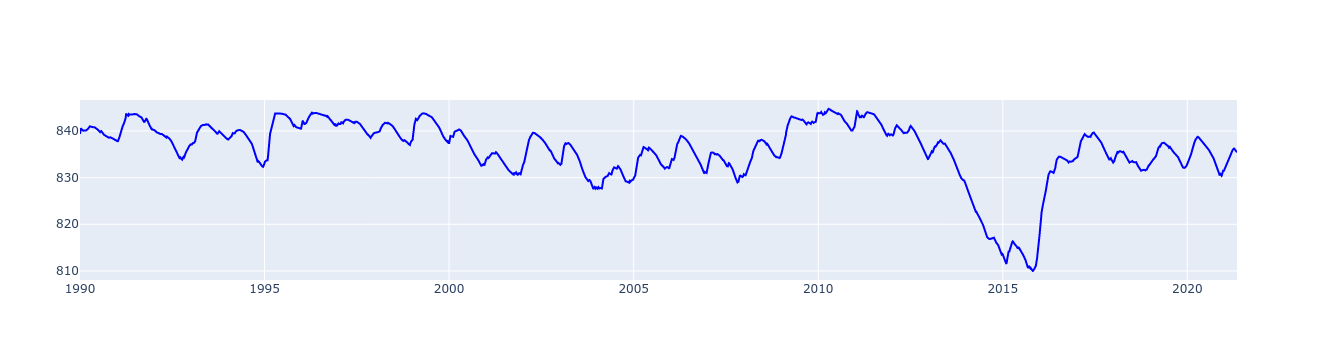

In [116]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)

plt_jj, fig_jj = get_graph_reservatorios(df['data'], df['jaguari_jacarei_nivel'])
fig_jj

<br>

# Graph Forecast

In [117]:
def get_forecast_data(df):
    # Soma a vazão de jusante
    df['qjusante'] = (
            df['jaguari_jacarei_qjusante'] +
            df['cachoeira_qjusante'] +
            df['atibainha_qjusante']
    )

    # Converte a vazão de jusante para hm3
    df['hm3jusante'] = df['qjusante'].apply(m3s_2_hm3)

    # Seleciona Colunas de Interesse
    df = df[['data', 'qjusante', 'hm3jusante']].copy()

    # Definição do Período Seco
    dia = date.today().strftime('%Y-%m-%d')
    dia = date.today()
    periodo, days2end_periodo, periodoseco_start, periodoseco_end = set_periodo(dia)

    if periodo == 'Período Seco':
        max_date = max(df['data'])
        df_periodoseco = df[df['data'] >= pd.Timestamp(periodoseco_start)]
        hm3_today = sum(df_periodoseco['hm3jusante'])
        hm3_periodoseco = 158.1
        hm3_balance = hm3_periodoseco-hm3_today
        hm3_forecast = hm3_balance/days2end_periodo
        m3s_forecast = hm3_2_m3s(hm3_forecast)

        # Define Parâmetros para criar uma tabela iniciando com o dia de amanhã
        start = (date.today() + timedelta(1)).strftime('%Y-%m-%d')
        end = periodoseco_end.strftime('%Y-%m-%d')
        df_forecast = pd.DataFrame(pd.date_range(pd.to_datetime(start), end=pd.to_datetime(end)), columns=['data'])
        df_forecast['qjusante'] = m3s_forecast
        df_forecast['hm3jusante'] = hm3_forecast

        # Adiciona a tabela
        df = df.append(df_forecast, ignore_index=True)
        df = df.sort_values('data')

        # Variaveis para Exportar
        hm3_periodoseco = round(hm3_periodoseco, 2)
        hm3_today = round(hm3_today, 2)
        hm3_balance = round(hm3_balance, 2)
        hm3_forecast = round(hm3_forecast, 2)
        m3s_forecast = round(m3s_forecast, 2)
        max_date = max_date.strftime('%d.%m.%Y')

        return (
            df,
            hm3_periodoseco,
            hm3_today,
            hm3_balance,
            hm3_forecast,
            m3s_forecast,
            max_date,
        )
    if periodo == 'Período Úmido':
        #TODO: Ajustar toda essa sessão sobre periodo úmido.
        max_date = max(df['data'])
        df_periodoseco = df[df['data'] >= pd.Timestamp(periodoseco_start)]
        hm3_today = sum(df_periodoseco['hm3jusante'])
        hm3_periodoseco = 158.1
        hm3_balance = hm3_periodoseco-hm3_today
        hm3_forecast = hm3_balance/days2end_periodo
        m3s_forecast = hm3_2_m3s(hm3_forecast)

        # Define Parâmetros para criar uma tabela iniciando com o dia de amanhã
        start = (date.today() + timedelta(1)).strftime('%Y-%m-%d')
        end = periodoseco_end.strftime('%Y-%m-%d')
        df_forecast = pd.DataFrame(pd.date_range(pd.to_datetime(start), end=pd.to_datetime(end)), columns=['data'])
        df_forecast['qjusante'] = m3s_forecast
        df_forecast['hm3jusante'] = hm3_forecast

        # Adiciona a tabela
        df = df.append(df_forecast, ignore_index=True)
        df = df.sort_values('data')

        # Variaveis para Exportar
        hm3_periodoseco = round(hm3_periodoseco, 2)
        hm3_today = round(hm3_today, 2)
        hm3_balance = round(hm3_balance, 2)
        hm3_forecast = round(hm3_forecast, 2)
        m3s_forecast = round(m3s_forecast, 2)
        max_date = max_date.strftime('%d.%m.%Y')

        return (
            df,
            hm3_periodoseco,
            hm3_today,
            hm3_balance,
            hm3_forecast,
            m3s_forecast,
            max_date,
        )

In [118]:
def get_graph_forecast(date_series, data_plot):
    # Graph Forecast
    fig = go.Figure()
    scatter = go.Scatter(
        x=date_series,
        y=data_plot,
        mode='lines',
        name='test',
        opacity=1,
        marker_color='blue'
    )

    fig.add_trace(scatter)
    plt = plot(fig, output_type='div', include_plotlyjs=False)    
    return plt, fig

In [119]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)
display(df.head())
display(df.tail())

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
0 1990-01-01              8.9           783.83                2.03   
1 1990-01-02             36.8           783.91                1.07   
2 1990-01-03             20.1           784.07                1.08   
3 1990-01-04              1.4           784.14                1.08   
4 1990-01-05             21.4           784.17                1.09   

   atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
0        238.114230              301.529768              171.244957   
1        239.689515              301.529768              171.244957   
2        242.856146              301.529768              171.244957   
3        244.248284              301.529768              171.244957   
4        244.846170              301.529768              171.244957   

   atibainha_volumeoperacional  atibainha_volumeporcentagem  \
0                    66.869273                    51.325456   
1                    68.444558                    52.534564   
2                    71.611189                    54.965110   
3                    73.003327                    56.033644   
4                    73.601214                    56.492551   

   atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
0             238.114230  ...               NaN              NaN   
1             239.689515  ...               NaN              NaN   
2             242.856146  ...               NaN              NaN   
3             244.248284  ...               NaN              NaN   
4             244.846170  ...               NaN              NaN   

   sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
0              NaN                NaN               NaN   
1              NaN                NaN               NaN   
2              NaN                NaN               NaN   
3              NaN                NaN               NaN   
4              NaN                NaN               NaN   

   sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  url  \
0                      NaN                   NaN                NaN  NaN   
1                      NaN                   NaN                NaN  NaN   
2                      NaN                   NaN                NaN  NaN   
3                      NaN                   NaN                NaN  NaN   
4                      NaN                   NaN                NaN  NaN   

   created_date  
0           NaT  
1           NaT  
2           NaT  
3           NaT  
4           NaT  

[5 rows x 98 columns]

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
292 2021-05-03              0.0          783.729                4.13   
293 2021-05-04              0.0          783.710                5.50   
294 2021-05-05              0.0          783.690                5.50   
295 2021-05-06              0.0          783.665                5.50   
296 2021-05-07              0.0          783.650                5.50   

     atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
292        233.793663              295.456327              199.204147   
293        233.424624              295.456327              199.204147   
294        233.036466              295.456327              199.204147   
295        232.551709              295.456327              199.204147   
296        232.261090              295.456327              199.204147   

     atibainha_volumeoperacional  atibainha_volumeporcentagem  \
292                    34.589516                    35.936346   
293                    34.220477                    35.552937   
294                    33.832319                    35.149666   
295                    33.347562                    34.646033   
296                    33.056943                    34.344098   

     atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
292             233.793663  ...            19.928            10.73   
293             233.424624  ...            12.996            12.10   
294             233.036466  ...            16.356            12.10   
295             232.551709  ...            21.912            11.69   
296             232.261090  ...            13.384            11.69   

     sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
292           12.258           20.45416          20.45958   
293            5.342           22.28948          22.29635   
294            8.708           21.87057          21.87074   
295           15.156           21.63360          21.64751   
296            5.784           22.09928          22.09838   

     sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  \
292                496.01506              50.50700         1007.42373   
293                494.26057              50.32834         1005.66924   
294                492.80606              50.18024         1004.21472   
295                491.86465              50.08438         1003.27332   
296                490.19744              49.91461         1001.60611   

                                                   url  \
292  http://mananciais.sabesp.com.br/api/Mananciais...   
293  http://mananciais.sabesp.com.br/api/Mananciais...   
294  http://mananciais.sabesp.com.br/api/Mananciais...   
295  http://mananciais.sabesp.com.br/api/Mananciais...   
296  http://mananciais.sabesp.com.br/api/Mananciais...   

                        created_date  
292 2021-05-03 13:01:21.463660+00:00  
293 2021-05-04 13:00:41.676851+00:00  
294 2021-05-05 13:00:47.036276+00:00  
295 2021-05-06 13:01:36.728367+00:00  
296 2021-05-07 13:01:09.612008+00:00  

[5 rows x 98 columns]

In [120]:
df, hm3_periodoseco, hm3_today, hm3_balance, hm3_forecast, m3s_forecast, max_date = get_forecast_data(df)

In [121]:
print(
    'Até o dia de "{}" já foi vertido o equivalente \
    a "{}" hm3, restando um "saldo" de "{}" hm3 \
    até o final do Período Seco. Esse valor equivale a verter, de modo constante,\
    "{}" m3/s até o final do Período Seco, \
    ou "{}" hm3 por dia'.format(max_date, hm3_today, hm3_balance,m3s_forecast,hm3_forecast)
)

Até o dia de "07.05.2021" já foi vertido o equivalente     a "0" hm3, restando um "saldo" de "158.1" hm3     até o final do Período Seco. Esse valor equivale a verter, de modo constante,    "17.1" m3/s até o final do Período Seco,     ou "1.48" hm3 por dia


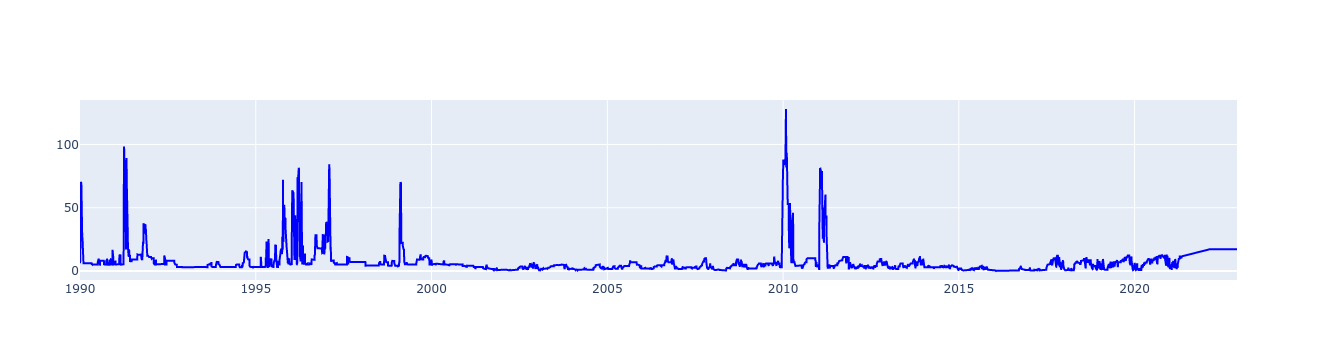

In [122]:
plt, fig = get_graph_forecast(df['data'], df['qjusante'])
fig

In [123]:
def get_graph_forecast(date_series, data_plot, max_date_db):
    # Definição do Período Seco
    periodo, days2end_periodo, periodoseco_start, periodoseco_end = set_periodo(date.today())

    # Get Middle Date
    x1 = get_middle_date(min(date_series).date(), max_date_db)
    x2 = get_middle_date(max_date_db, periodoseco_end)

    # Graph
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=date_series,
            y=data_plot,
            mode='lines',
            name='QJus',
            text='m³/s',
            showlegend=False,
            line=dict(
                shape='linear',
                color='#000066',
                width=0.8,
            )
        ))
    fig.add_shape(
        dict(
            type='rect',
            x0=min(date_series),
            x1=max_date_db,
            yref='paper',
            y0=0,
            y1=1,
            fillcolor='#6ed69f',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='#f4f3ca',
                width=1
            ),
        )
    )
    fig.add_shape(
        dict(
            type='rect',
            x0=max_date_db,
            x1=periodoseco_end,
            yref='paper',
            y0=0,
            y1=1,
            fillcolor='#ecb50c',
            opacity=0.5,
            layer='below',
            line_width=0,
            line=dict(
                color='#f4f3ca',
                width=1
            ),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[x1, x2],
            y=[10, 2],
            text=['Passado', 'Futuro'],
            mode='text',
            showlegend=False,
            hoverinfo='none',
        ))
    start_date = date(2017, 5, 29)
    fig.update_layout(
        yaxis={
            'title': 'Vazão (m³/s)',
            'range': [0, 14]
        },
        xaxis={'range': [start_date, max(date_series)]},
        yaxis_tickformat='.2',
        xaxis_tickformat='%d %b<br>%Y',
        showlegend=False,
        hovermode='x',
    )
    config = {'displaylogo': False}
    plt = plot(fig, output_type='div', include_plotlyjs=False, config=config)
    return plt, fig

In [124]:
print(
    'Até o dia de "{}" já foi vertido o equivalente \
    a "{}" hm3, restando um "saldo" de "{}" hm3 \
    até o final do Período Seco. Esse valor equivale a verter, de modo constante,\
    "{}" m3/s até o final do Período Seco, \
    ou "{}" hm3 por dia'.format(max_date, hm3_today, hm3_balance,m3s_forecast,hm3_forecast)
)

Até o dia de "07.05.2021" já foi vertido o equivalente     a "0" hm3, restando um "saldo" de "158.1" hm3     até o final do Período Seco. Esse valor equivale a verter, de modo constante,    "17.1" m3/s até o final do Período Seco,     ou "1.48" hm3 por dia


2022-11-30


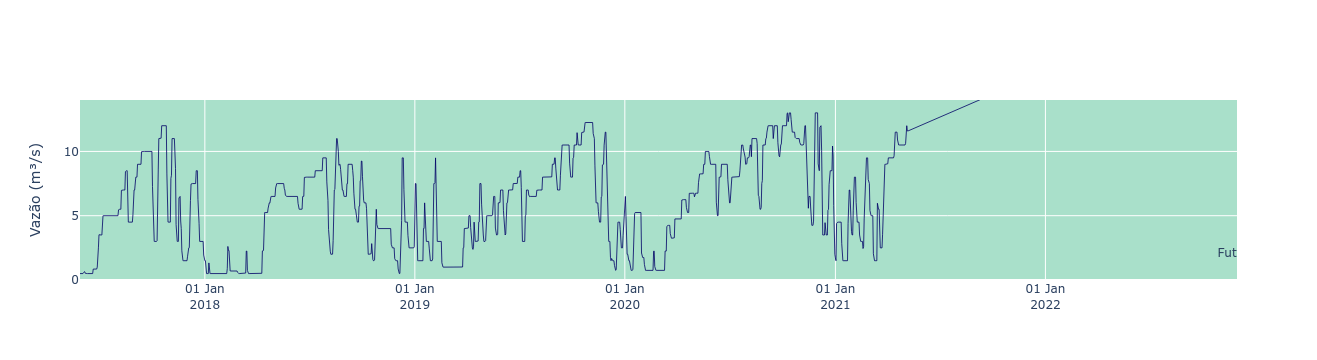

In [125]:
max_date_db = max(df['data']).date()
print(max_date_db)

plt, fig = get_graph_forecast(df['data'], df['qjusante'], max_date_db)
fig

<br>

# Graph Vazões Mínimas

In [126]:
def get_qmin_data(df):
    # Filtra Tabela
    start_date = '2017-05-29'
    df = df[df['data'] >= pd.Timestamp(start_date)]

    # Vazão dos Cursos d'água
    df['jaguari_qjusante'] = df['jaguari_jacarei_qjusante']
    df['atibaia_qjusante'] = (df['cachoeira_qjusante'] + df['atibainha_qjusante'])
    df['juqueri_qjusante'] = df['paivacastro_qjusante']
    
    return df

In [127]:
def get_graph_qmin(date_series, data_plot, qminima):
    # Graph Q minima
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=date_series,
            y=data_plot,
            mode='lines',
            name='test',
            opacity=1,
            marker_color='blue'
        )
    )
    fig.add_shape(
        dict(
            type='line',
            x0=min(date_series),
            y0=qminima,
            x1=max(date_series),
            y1=qminima,
            layer='above',
            line=dict(
                color='Red',
                width=2,
                dash='dashdot',
            ),
        ))

    # Layout
    fig.update_layout(
        yaxis={'title': 'Vazão (m³/s)'},
    )
    fig.update_layout(yaxis_tickformat='.2')
    fig.update_layout(xaxis_tickformat='%d %B<br>%Y')
    fig.update_layout(showlegend=False)

    plt = plot(fig, output_type='div', include_plotlyjs=False)

    return plt, fig

/tmp/ipykernel_72151/2222759435.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_72151/2222759435.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_72151/2222759435.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



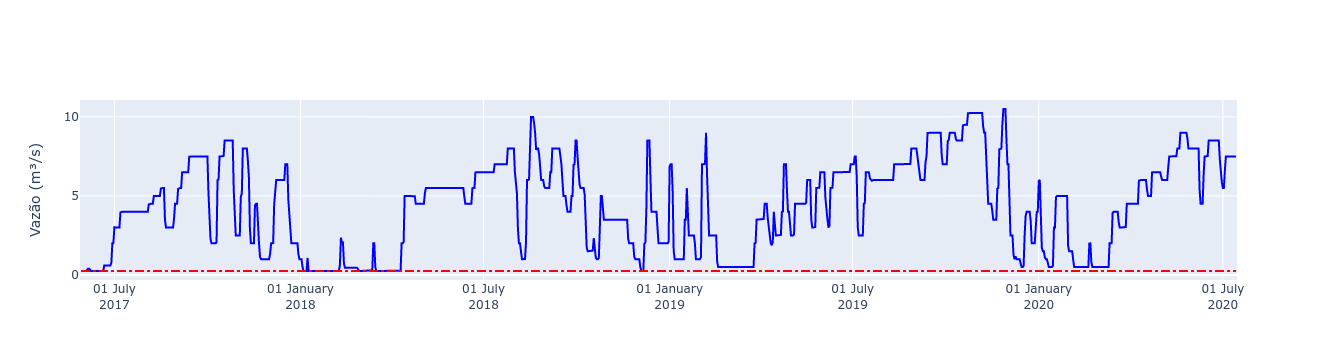

In [128]:
df = get_df_compiled(in_django)
df = get_qmin_data(df)

plt_jaguari, fig_jaguari = get_graph_qmin(df['data'], df['jaguari_qjusante'], qminima=0.25)
plt_atibaia, fig_atibaia = get_graph_qmin(df['data'], df['atibaia_qjusante'], qminima=0.25)
plt_juqueri, fig_juqueri = get_graph_qmin(df['data'], df['juqueri_qjusante'], qminima=0.1)
#fig_jaguari
fig_atibaia
#fig_juqueri
#fig_aguasclaras

<br>

# Vazões de Retirada

In [129]:
def set_limiteretirada(faixa_id):
    # Seleciona a Faixa
    if faixa_id == 1:
        limite_retirada = 33
    elif faixa_id == 2:
        limite_retirada = 31
    elif faixa_id == 3:
        limite_retirada = 27
    elif faixa_id == 4:
        limite_retirada = 23
    elif faixa_id == 5:
        limite_retirada = 15.5
        
    return limite_retirada

In [130]:
def get_qretirada_data(df):
    # Filtra Tabela
    start_date = '2017-05-29'
    df = df[df['data'] >= pd.Timestamp(start_date)]
    
    # Filtra Colunas
    df = df[[
        'data',
        'jaguari_jacarei_volume', 'cachoeira_volume', 'atibainha_volume', 'paivacastro_volume',
        'jaguari_jacarei_volumemaximo', 'cachoeira_volumemaximo',
        'atibainha_volumemaximo', 'paivacastro_volumemaximo',
        'qesi_valor', 'sc_vazaoretirada', 'sc_vazaojusante',
    ]]       
    
    # Calcula Campo
    df['sc_calc_volumeporcentagem'] = (
        df['jaguari_jacarei_volume'] +
        df['cachoeira_volume'] +
        df['atibainha_volume'] +
        df['paivacastro_volume']) / (
        df['jaguari_jacarei_volumemaximo'] +
        df['cachoeira_volumemaximo'] +
        df['atibainha_volumemaximo'] +
        df['paivacastro_volumemaximo']
    )

    df[['faixa', 'faixa_id']] = df.apply(lambda x: set_faixas(x['sc_calc_volumeporcentagem']),
                                          axis=1, result_type='expand')
    df['limiteretirada'] = df.apply(lambda x: set_limiteretirada(x['faixa_id']), axis=1)
    
    return df

In [131]:
df = get_df_compiled(in_django)
df = get_qretirada_data(df)

df.head(5)

data  jaguari_jacarei_volume  cachoeira_volume  atibainha_volume  \
2705 2017-05-29              825.341740         79.759922        242.715601   
2706 2017-05-30              826.650021         80.108153        240.859095   
2707 2017-05-31              827.522872         80.457375        238.891693   
2708 2017-06-01              828.833141         80.877750        237.323411   
2709 2017-06-02              830.144601         81.229157        235.760140   

      paivacastro_volume  jaguari_jacarei_volumemaximo  \
2705           27.656936                   1047.493011   
2706           27.575499                   1047.493011   
2707           28.025335                   1047.493011   
2708           27.902184                   1047.493011   
2709           27.738529                   1047.493011   

      cachoeira_volumemaximo  atibainha_volumemaximo  \
2705              116.572359              295.456327   
2706              116.572359              295.456327   
2707              116.572359              295.456327   
2708              116.572359              295.456327   
2709              116.572359              295.456327   

      paivacastro_volumemaximo  qesi_valor  sc_vazaoretirada  sc_vazaojusante  \
2705                 32.930834       23.38               NaN              NaN   
2706                 32.930834       24.89               NaN              NaN   
2707                 32.930834       22.99               NaN              NaN   
2708                 32.930834       25.34               NaN              NaN   
2709                 32.930834       24.56               NaN              NaN   

      sc_calc_volumeporcentagem             faixa  faixa_id  limiteretirada  
2705                   0.787612  Faixa 1 (Normal)         1              33  
2706                   0.787424  Faixa 1 (Normal)         1              33  
2707                   0.787226  Faixa 1 (Normal)         1              33  
2708                   0.787252  Faixa 1 (Normal)         1              33  
2709                   0.787209  Faixa 1 (Normal)         1              33

In [132]:
def get_graph_qretirada(df):
    # Graph Q minima
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df['data'],
            y=df['sc_vazaoretirada'],
            mode='lines',
            name='Q ETA Guaraú',
            opacity=1,
            marker_color='blue'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df['data'],
            y=df['limiteretirada'],
            mode='lines',
            name='Limite Retirada RMSP',
            opacity=1,
            marker_color='black'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df['data'],
            y=df['qesi_valor'],
            mode='lines',
            name='Q ESI',
            opacity=1,
            marker_color='red'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df['data'],
            y=df['sc_vazaojusante'],
            mode='lines',
            name='Q Jusante',
            opacity=1,
            marker_color='green'
        )
    )

    # Layout
    fig.update_layout(
        yaxis={'title': 'Vazão (m³/s)'},
    )
    #fig.update_layout(yaxis_tickformat='.2')
    fig.update_layout(xaxis_tickformat='%d %B<br>%Y')
    fig.update_layout(showlegend=False)

    plt = plot(fig, output_type='div', include_plotlyjs=False)

    return plt, fig

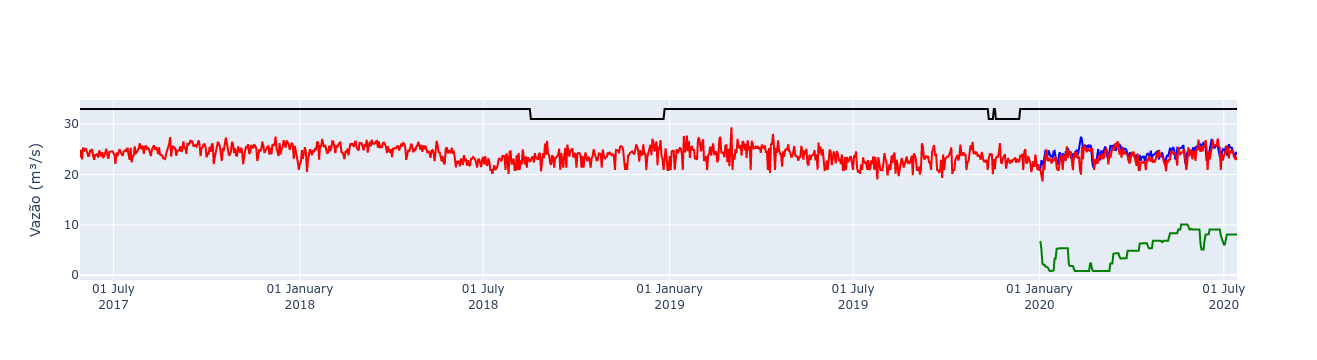

In [133]:
plt, fig = get_graph_qretirada(df)
fig

<br>

# Outras

<br>

# Calcula Colunas

In [134]:
df = get_df_compiled(in_django)
df = concat_dfdb(df)
display(df.head())
df.columns

data  atibainha_chuva  atibainha_nivel  atibainha_qjusante  \
0 1990-01-01              8.9           783.83                2.03   
1 1990-01-02             36.8           783.91                1.07   
2 1990-01-03             20.1           784.07                1.08   
3 1990-01-04              1.4           784.14                1.08   
4 1990-01-05             21.4           784.17                1.09   

   atibainha_volume  atibainha_volumemaximo  atibainha_volumeminimo  \
0        238.114230              301.529768              171.244957   
1        239.689515              301.529768              171.244957   
2        242.856146              301.529768              171.244957   
3        244.248284              301.529768              171.244957   
4        244.846170              301.529768              171.244957   

   atibainha_volumeoperacional  atibainha_volumeporcentagem  \
0                    66.869273                    51.325456   
1                    68.444558                    52.534564   
2                    71.611189                    54.965110   
3                    73.003327                    56.033644   
4                    73.601214                    56.492551   

   atibainha_volumetotal  ...  sc_vazaoafluente  sc_vazaojusante  \
0             238.114230  ...               NaN              NaN   
1             239.689515  ...               NaN              NaN   
2             242.856146  ...               NaN              NaN   
3             244.248284  ...               NaN              NaN   
4             244.846170  ...               NaN              NaN   

   sc_vazaonatural  sc_vazaoproduzida  sc_vazaoretirada  \
0              NaN                NaN               NaN   
1              NaN                NaN               NaN   
2              NaN                NaN               NaN   
3              NaN                NaN               NaN   
4              NaN                NaN               NaN   

   sc_volumeoperacionalhm3  sc_volumeporcentagem  sc_volumetotalhm3  url  \
0                      NaN                   NaN                NaN  NaN   
1                      NaN                   NaN                NaN  NaN   
2                      NaN                   NaN                NaN  NaN   
3                      NaN                   NaN                NaN  NaN   
4                      NaN                   NaN                NaN  NaN   

   created_date  
0           NaT  
1           NaT  
2           NaT  
3           NaT  
4           NaT  

[5 rows x 98 columns]

Index(['data', 'atibainha_chuva', 'atibainha_nivel', 'atibainha_qjusante',
       'atibainha_volume', 'atibainha_volumemaximo', 'atibainha_volumeminimo',
       'atibainha_volumeoperacional', 'atibainha_volumeporcentagem',
       'atibainha_volumetotal', 'cachoeira_chuva', 'cachoeira_nivel',
       'cachoeira_qjusante', 'cachoeira_volume', 'cachoeira_volumemaximo',
       'cachoeira_volumeminimo', 'cachoeira_volumeoperacional',
       'cachoeira_volumeporcentagem', 'cachoeira_volumetotal',
       'jaguari_cesp_chuva', 'jaguari_cesp_nivel', 'jaguari_cesp_qjusante',
       'jaguari_cesp_volume', 'jaguari_cesp_volumemaximo',
       'jaguari_cesp_volumeminimo', 'jaguari_cesp_volumeoperacional',
       'jaguari_cesp_volumeporcentagem', 'jaguari_cesp_volumetotal',
       'jaguari_jacarei_chuva', 'jaguari_jacarei_nivel',
       'jaguari_jacarei_qjusante', 'jaguari_jacarei_volume',
       'jaguari_jacarei_volumemaximo', 'jaguari_jacarei_volumeminimo',
       'jaguari_jacarei_volumeoperacional'

In [135]:
df['mes'] = df['data'].dt.month
df['ano'] = df['data'].dt.year

In [136]:
#df = df.groupby(['ano', 'mes']).mean()
#df = df.reset_index()

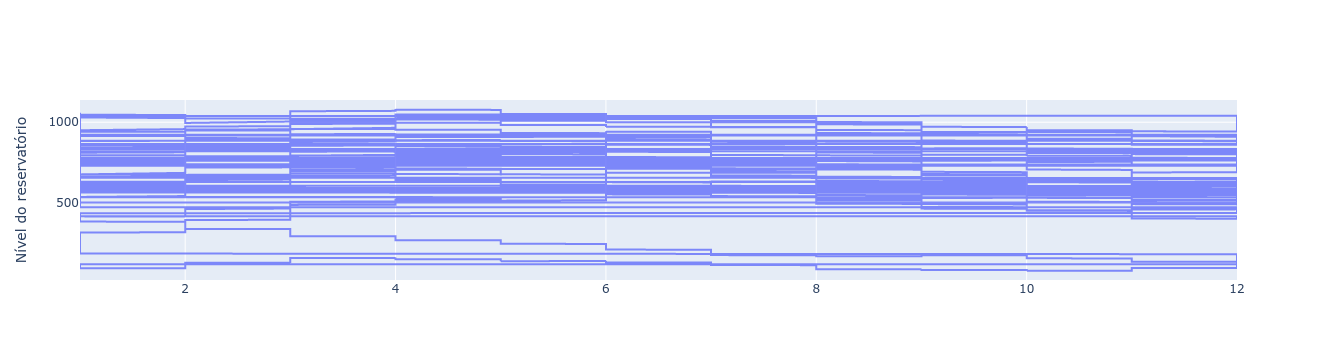

In [137]:
# Criando gráfico
trace = go.Scatter(
    x=df['mes'],
    y=df['jaguari_jacarei_volume'],
    mode = 'lines',
    opacity=0.8
)

# Armazenando gráfico em uma lista
data = [trace]

# Criando Layout
layout = go.Layout(yaxis={'title':'Nível do reservatório'})

# Criando figura que será exibida
fig = go.Figure(data=data, layout=layout)

# Exibindo figura/gráfico
py.iplot(fig)

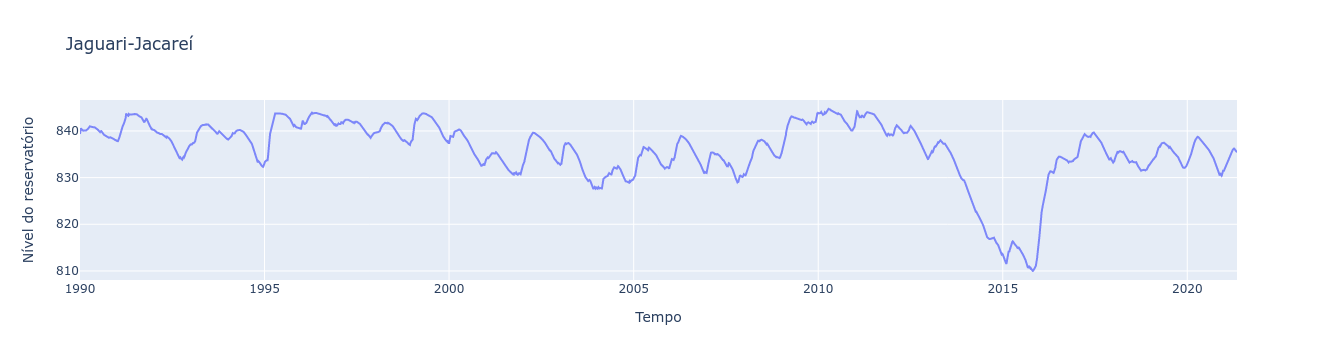

In [138]:
# Criando gráfico
trace = go.Scatter(
    x=df['data'],
    y=df['jaguari_jacarei_nivel'],
    mode='lines',
    opacity=0.8
)

# Armazenando gráfico em uma lista
data = [trace]

# Criando Layout
layout = go.Layout(
    title='Jaguari-Jacareí',
    yaxis={'title':'Nível do reservatório'},
    xaxis={'title': 'Tempo'}
)

# Criando figura que será exibida
fig = go.Figure(data=data, layout=layout)

# Exibindo figura/gráfico
py.iplot(fig)

<br>

# Export

In [139]:
import os
from traitlets.config import Config
from nbconvert import PythonExporter
from nbconvert.preprocessors import TagRemovePreprocessor

In [140]:
input_filename = '2_analysis.ipynb'
input_filepath = os.path.join(os.getcwd(), input_filename)

In [141]:
# Import the exporter
c = Config()
c.TagRemovePreprocessor.enabled=True
c.ClearOutputPreprocessor.enabled=True
c.TemplateExporter.exclude_markdown=True
c.TemplateExporter.exclude_code_cell=False
c.TemplateExporter.exclude_input_prompt=True
c.TemplateExporter.exclude_output=True
c.TemplateExporter.exclude_raw=True
c.TagRemovePreprocessor.remove_cell_tags = ('remove_cell',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_cell',)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.preprocessors = ['TagRemovePreprocessor']
c.PythonExporter.preprocessors = ['nbconvert.preprocessors.TagRemovePreprocessor']

# Configure and run out exporter
py_exporter = PythonExporter(config=c)
py_exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)

# Configure and run out exporter - returns a tuple - first element with html, second with notebook metadata
body, metadata = PythonExporter(config=c).from_filename(input_filepath)

# Write to output html file
with open(os.path.join(os.getcwd(), '..', 'src', 'analysis.py'),  'w', encoding='utf-8') as f:
    f.write(body)